# Statistics

Chapter 11 of Python for Finance (continued)

Hilpisch, Yves. Python for Finance: Analyze Big Financial Data. O'Reilly Media. Kindle Edition.

* Bayesian Regression

## Bayes Formula:
* p(H): prior probability
* p(D): probability for the data under any hypothesis, also called the normalizing constant
* p(D|H): likelihood (i.e. probability) of the data under the hypothesis H
* p(H|D): posterior probability; ie after we've seen the data

$$ p(H|D) = \frac{p(H)p(D|H)}{p(D)}$$

In [1]:
import pymc3 as pm
import numpy as np
np.random.seed(1000)
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
x = np.linspace(0, 10, 500)
y = 4 + 2*x + np.random.standard_normal(len(x))*2

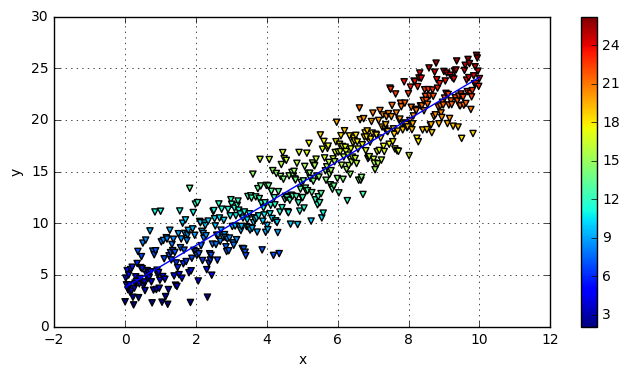

In [3]:
reg = np.polyfit(x, y, 1) # linear regression

plt.figure(figsize=(8,4))
plt.scatter(x, y, c = y, marker = 'v')
plt.plot(x, reg[1] + reg[0]*x, lw=1.0)
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

In [4]:
reg

array([ 2.03384161,  3.77649234])

In [5]:
with pm.Model() as model:
    # model specifications in PyMC3 are wrapped in a with statement
    # define priors
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    #define linear regression
    y_est = alpha + beta*x
    
    #define likelihood
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    
    #inference
    start = pm.find_MAP()  #find starting value by optimization
    step = pm.NUTS(state=start) #initiate MCMC sampling algorithm
    trace = pm.sample(100, step, start=start, progressbar=False) #draw 100 posterior samples using NUTS sampling

Applied interval-transform to sigma and added transformed sigma_interval_ to model.


In [6]:
trace[0]

{'alpha': 3.9240065171325469,
 'beta': 2.0242759725163029,
 'sigma': 2.0071601413413478,
 'sigma_interval_': -1.3818252652128997}

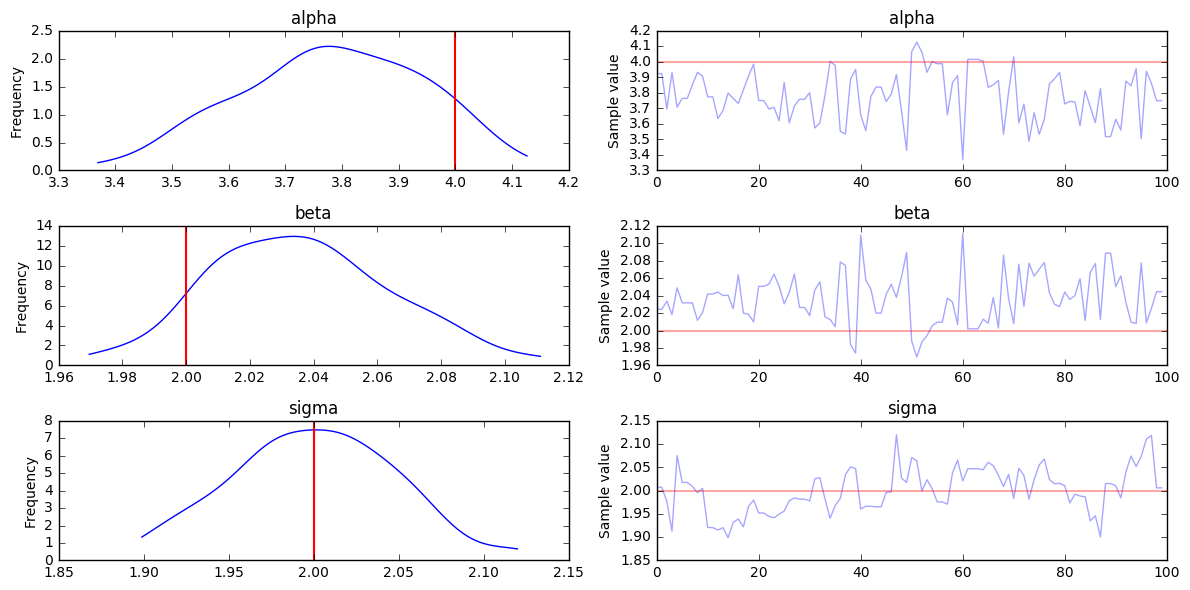

In [7]:
fig = pm.traceplot(trace, lines={'alpha':4, 'beta':2, 'sigma':2})
plt.figure(figsize=(8,8))

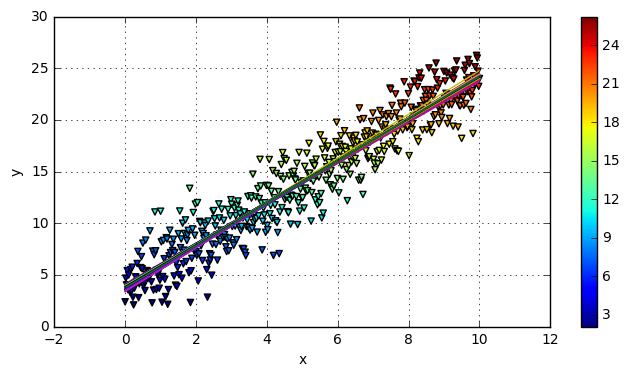

In [8]:
plt.figure(figsize=(8,4))
plt.scatter(x, y, c=y, marker='v')
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i]+trace['beta'][i]*x)

## Real Data

In [9]:
import warnings
warnings.simplefilter('ignore')
import zipline
import pytz
import datetime as dt

In [10]:
data = zipline.data.load_from_yahoo(stocks=['GLD','GDX'], end=dt.datetime(2016, 11, 15, 0, 0, 0, 0, pytz.utc)).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2642 entries, 2006-05-22 to 2016-11-15
Data columns (total 2 columns):
GDX    2642 non-null float64
GLD    2642 non-null float64
dtypes: float64(2)
memory usage: 61.9 KB


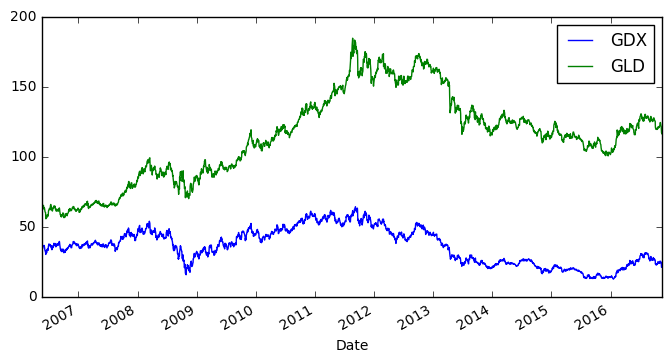

In [11]:
data.plot(figsize=(8,4))

In [12]:
data.ix[-1] / data.ix[0]-1

GDX   -0.367969
GLD    0.793568
dtype: float64

In [13]:
data.corr()

,GDX,GLD
GDX,1.00000,0.29964
GLD,0.29964,1.00000


In [14]:
data.index

DatetimeIndex(['2006-05-22', '2006-05-23', '2006-05-24', '2006-05-25',
               '2006-05-26', '2006-05-30', '2006-05-31', '2006-06-01',
               '2006-06-02', '2006-06-05',
               ...
               '2016-11-02', '2016-11-03', '2016-11-04', '2016-11-07',
               '2016-11-08', '2016-11-09', '2016-11-10', '2016-11-11',
               '2016-11-14', '2016-11-15'],
              dtype='datetime64[ns, UTC]', name='Date', length=2642, freq=None)

In [15]:
import matplotlib as mpl
mpl_dates = mpl.dates.date2num(data.index.tolist())
mpl_dates

array([ 732453.,  732454.,  732455., ...,  736279.,  736282.,  736283.])

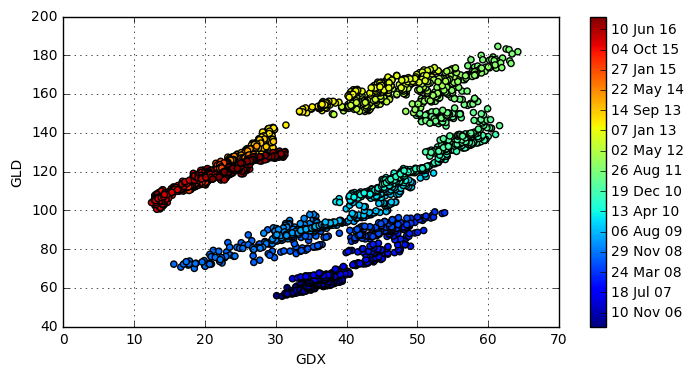

In [16]:
plt.figure(figsize=(8,4))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='o')
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))

In [17]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    y_est = alpha + beta*data['GDX'].values
    
    likelihood = pm.Normal('GLD', mu=y_est, sd=sigma, observed = data['GLD'].values)
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(100, step, start=start, progressbar=True)

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:42<00:00,  5.31s/it]


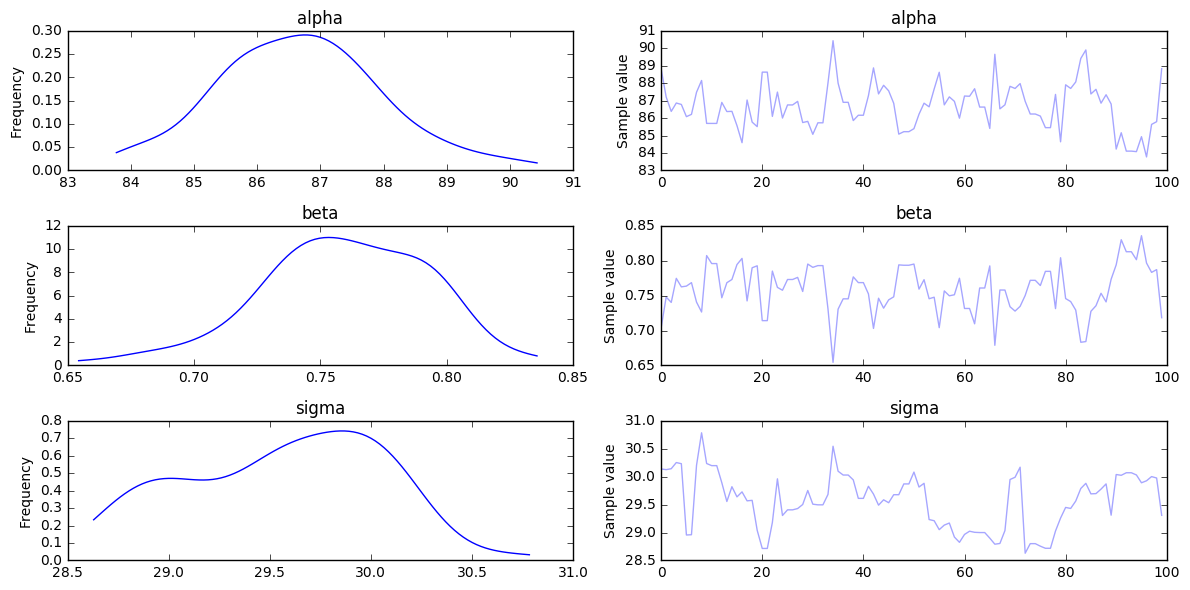

In [18]:
fig = pm.traceplot(trace)
plt.figure(figsize=(8,8))

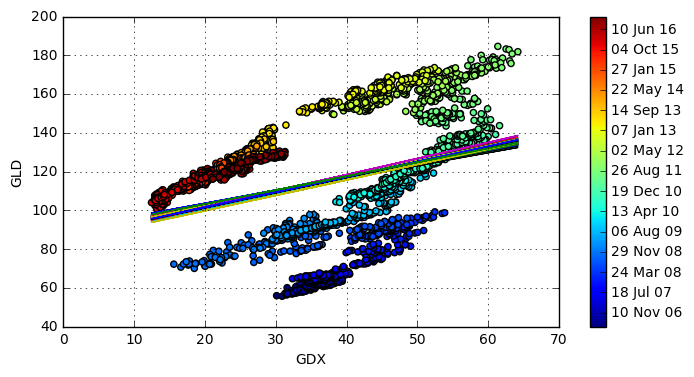

In [19]:
plt.figure(figsize=(8,4))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='o')
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
for i in range(len(trace)):
    plt.plot(data['GDX'], trace['alpha'][i] + trace['beta'][i]*data['GDX'])

plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))

In [20]:
model_randomwalk = pm.Model()
with model_randomwalk:
    # std of random walk best sampled in log space
    sigma_alpha = pm.Exponential('sigma_alpha', 1./0.02, testval=.1)
    sigma_beta = pm.Exponential('sigma_beta', 1./0.02, testval=.1)

Applied log-transform to sigma_alpha and added transformed sigma_alpha_log_ to model.
Applied log-transform to sigma_beta and added transformed sigma_beta_log_ to model.


In [21]:
from pymc3.distributions.timeseries import GaussianRandomWalk
# to make the model simpler, we'll apply the same coefficients
# to 50 datapoints at a time

subsample_alpha = 50
subsample_beta = 50

with model_randomwalk:
    alpha = GaussianRandomWalk('alpha', sigma_alpha**-2, shape=int(len(data)/subsample_alpha))
    beta = GaussianRandomWalk('beta', sigma_beta**-2, shape=int(len(data)/subsample_beta))
    
    #make coeffients have the same length as prices
    alpha_r = np.repeat(alpha, subsample_alpha)
    beta_r = np.repeat(beta, subsample_beta)

In [22]:
len(data.dropna().GDX.values)

2642

Need to round this down to a number divisible by 50 in order for the sampling to work.

In [23]:
data_cutoff = 2600

with model_randomwalk:
    #define regression
    regression = alpha_r + beta_r*data.GDX.values[:data_cutoff]
    
    #assume prices are normally distributed
    #the mean comes from the regression
    sd = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('GLD',mu=regression, sd=sd, observed=data.GLD.values[:data_cutoff])

Applied interval-transform to sd and added transformed sd_interval_ to model.


In [26]:
import scipy.optimize as sco
with model_randomwalk:
    #first optimize random walk
    start = pm.find_MAP(vars=[alpha, beta], fmin=sco.fmin_l_bfgs_b)
    
    #sampling
    step = pm.NUTS(scaling=start)
    trace_rw = pm.sample(100, step, start=start, progressbar=True)


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [12:02:47<00:00, 576.25s/it]


In [27]:
np.shape(trace_rw['alpha'])

(100, 52)

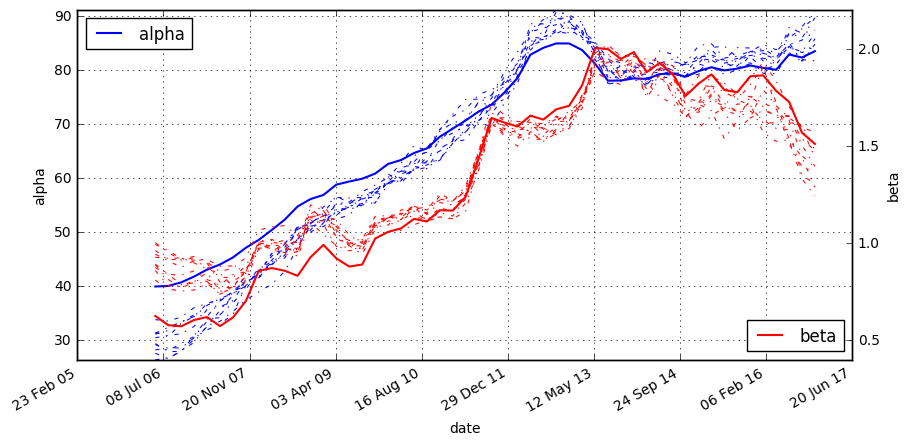

In [32]:
part_dates=np.linspace(min(mpl_dates), max(mpl_dates), 52)
fig, ax1 = plt.subplots(figsize=(10,5))
plt.plot(part_dates, np.mean(trace_rw['alpha'],axis=0),
        'b', lw=1.5, label='alpha')
for i in range(45, 55):
    plt.plot(part_dates, trace_rw['alpha'][i],'b-.', lw=0.75)
plt.xlabel('date')
plt.ylabel('alpha')
plt.axis('tight')
plt.grid(True)
plt.legend(loc=2)
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d %b %y'))
ax2 = ax1.twinx()
plt.plot(part_dates, np.mean(trace_rw['beta'],axis=0),'r', lw=1.5, label='beta')

for i in range(45, 55):
    plt.plot(part_dates, trace_rw['beta'][i],'r-.', lw=0.75)
plt.ylabel('beta')
plt.legend(loc=4)
fig.autofmt_xdate()

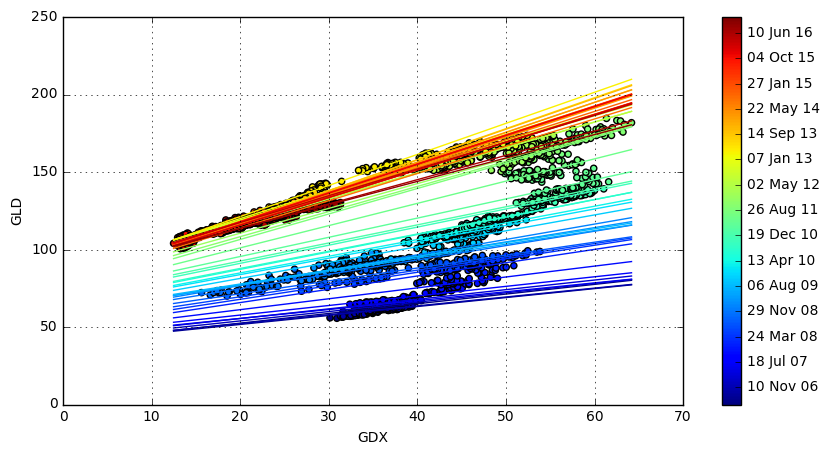

In [43]:
plt.figure(figsize =(10, 5)) 
plt.scatter(data['GDX'], data['GLD'], c = mpl_dates, marker ='o') 
plt.colorbar(ticks = mpl.dates.DayLocator(interval = 250), format = mpl.dates.DateFormatter('%d %b %y')) 
plt.grid(True)
plt.xlabel('GDX') 
plt.ylabel('GLD') 
x = np.linspace(min(data['GDX']), max(data['GDX']))

for i in range(52): 
    alpha_rw = np.mean(trace_rw['alpha'].T[i]) 
    beta_rw = np.mean(trace_rw['beta'].T[i]) 
    plt.plot(x, alpha_rw + beta_rw * x, color = plt.cm.jet(i/52))